In [ ]:
import requests
import pandas as pd

status_url = "https://velib-metropole-opendata.smovengo.cloud/opendata/Velib_Metropole/station_status.json"
status_data = requests.get(status_url).json()['data']['stations']
df_status = pd.DataFrame(status_data)

df_status[['station_id', 'numBikesAvailable', 'numDocksAvailable', 'is_renting', 'is_returning']].head(10)

,station_id,numBikesAvailable,numDocksAvailable,is_renting,is_returning
0,213688169,6,29,1,1
1,19179944124,10,18,1,1
2,36255,2,19,1,1
3,251039991,2,22,1,1
4,85002689,3,57,1,1
5,2515829865,5,17,1,1
6,516709288,6,13,1,1
7,120827885,3,8,1,1
8,66491398,2,45,1,1
9,37874517,7,14,1,1


In [ ]:
info_url = "https://velib-metropole-opendata.smovengo.cloud/opendata/Velib_Metropole/station_information.json"
info_data = requests.get(info_url).json()['data']['stations']
df_info = pd.DataFrame(info_data)

df_info[['station_id', 'name', 'lat', 'lon', 'capacity']].head(10)

,station_id,name,lat,lon,capacity
0,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35
1,19179944124,Hôpital Mondor,48.798922,2.453745,28
2,36255,Toudouze - Clauzel,48.879296,2.337360,21
3,251039991,Cassini - Denfert-Rochereau,48.837526,2.336035,25
4,85002689,Jourdan - Stade Charléty,48.819428,2.343335,60
5,2515829865,Basilique,48.936269,2.358867,22
6,516709288,Charonne - Robert et Sonia Delaunay,48.855908,2.392571,20
7,120827885,Messine - Place Du Pérou,48.875448,2.315508,12
8,66491398,Le Brun - Gobelins,48.835093,2.353468,48
9,37874517,Saint-Sulpice,48.851654,2.330808,21


In [ ]:
import pandas as pd

df = pd.merge(df_info, df_status, on='station_id', how='inner')

df = df[[
    'station_id', 'name', 'lat', 'lon', 'capacity',
    'numBikesAvailable', 'numDocksAvailable', 'is_installed', 'is_renting', 'is_returning'
]]
df.rename(columns={
    'name': 'station_name',
    'lat': 'latitude',
    'lon': 'longitude',
    'capacity': 'dock_capacity',
    'numBikesAvailable': 'bikes_available',
    'numDocksAvailable': 'docks_available',
    'is_installed': 'installed',
    'is_renting': 'renting',
    'is_returning': 'returning'
}, inplace=True)

df = df[df['dock_capacity'] > 0]
df['bike_utilization_%'] = (df['bikes_available'] / df['dock_capacity'] * 100).round(1)

df = df[df['bike_utilization_%'] <= 100]

top_100 = df.sort_values(by='bike_utilization_%', ascending=False).head(100)
top_30 = df.sort_values(by='bike_utilization_%', ascending=False).head(30)
top_10 = df.sort_values(by='bike_utilization_%', ascending=False).head(10)


top_10[['station_id', 'station_name', 'bike_utilization_%', 'bikes_available', 'dock_capacity']]

,station_id,station_name,bike_utilization_%,bikes_available,dock_capacity
230,649888071,Place Paul Eluard,100.0,19,19
1433,1062807847,BNF - Bibliothèque Nationale de France,100.0,42,42
1443,2515855808,Madeleine Vionnet,100.0,34,34
72,55927887,Gabriel Lamé,97.2,35,36
469,1002738770,Lavandieres Sainte Opportune - Rivoli,96.3,26,27
496,256561528,Eugène Oudiné - Dessous Des Berges,95.5,42,44
138,535500589,Hôpital Européen Georges Pompidou,95.3,61,64
1038,210386007,Alger - Rivoli,95.2,20,21
1360,19902592897,Les Planètes,95.2,20,21
499,1020700136,Neuve Saint-Pierre - Beautreillis,95.0,19,20


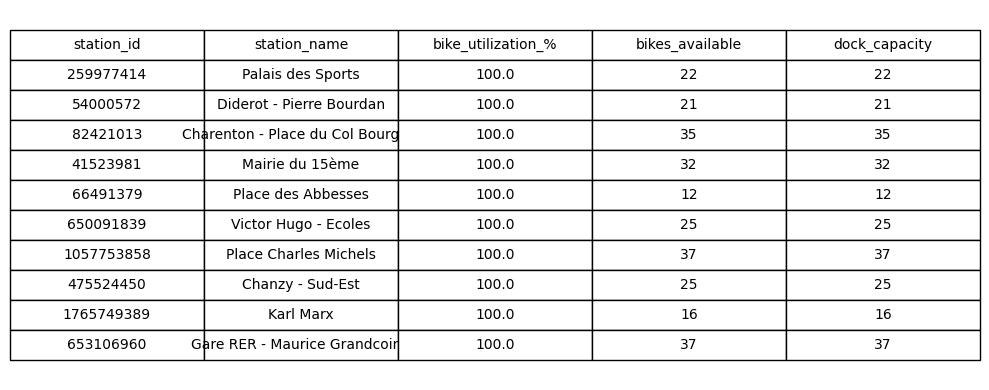

In [ ]:
import matplotlib.pyplot as plt

table_data = top_10[['station_id', 'station_name', 'bike_utilization_%', 'bikes_available', 'dock_capacity']]

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')
table = ax.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()
plt.savefig("top10_stations.png", dpi=300)
plt.show()

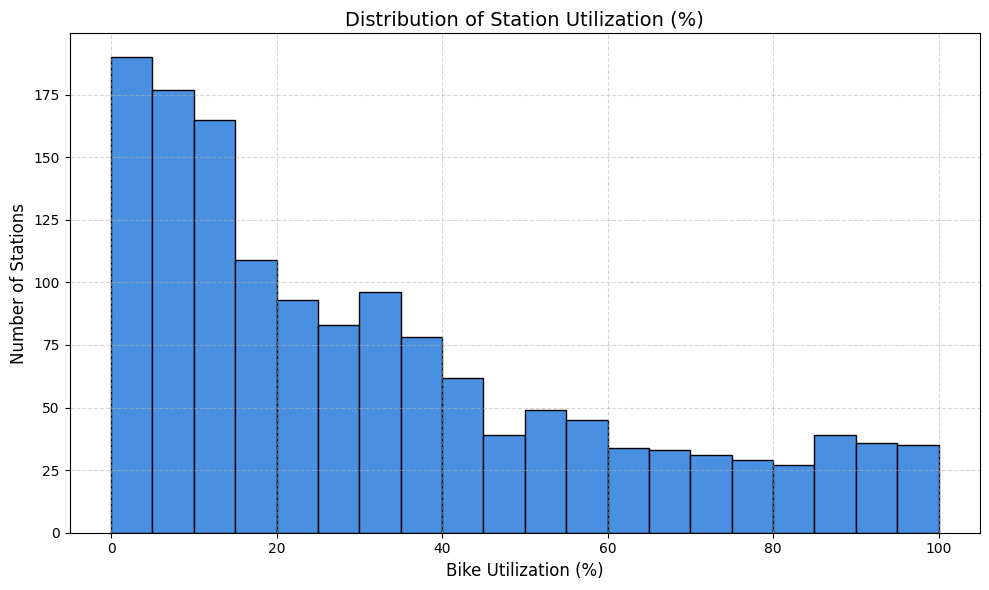

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Load both station info and status
info_url = "https://velib-metropole-opendata.smovengo.cloud/opendata/Velib_Metropole/station_information.json"
status_url = "https://velib-metropole-opendata.smovengo.cloud/opendata/Velib_Metropole/station_status.json"

info_data = requests.get(info_url).json()['data']['stations']
status_data = requests.get(status_url).json()['data']['stations']

# Convert to DataFrames
df_info = pd.DataFrame(info_data)
df_status = pd.DataFrame(status_data)

# Merge them on station_id
df = pd.merge(df_info, df_status, on='station_id')

# Calculate utilization (% of bikes relative to capacity)
df['bike_utilization_%'] = (df['numBikesAvailable'] / df['capacity']) * 100
df = df[(df['capacity'] > 0) & (df['bike_utilization_%'] <= 100)] # prevent division by zero

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['bike_utilization_%'], bins=20, color='#4a90e2', edgecolor='black')
plt.title("Distribution of Station Utilization (%)", fontsize=14)
plt.xlabel("Bike Utilization (%)", fontsize=12)
plt.ylabel("Number of Stations", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


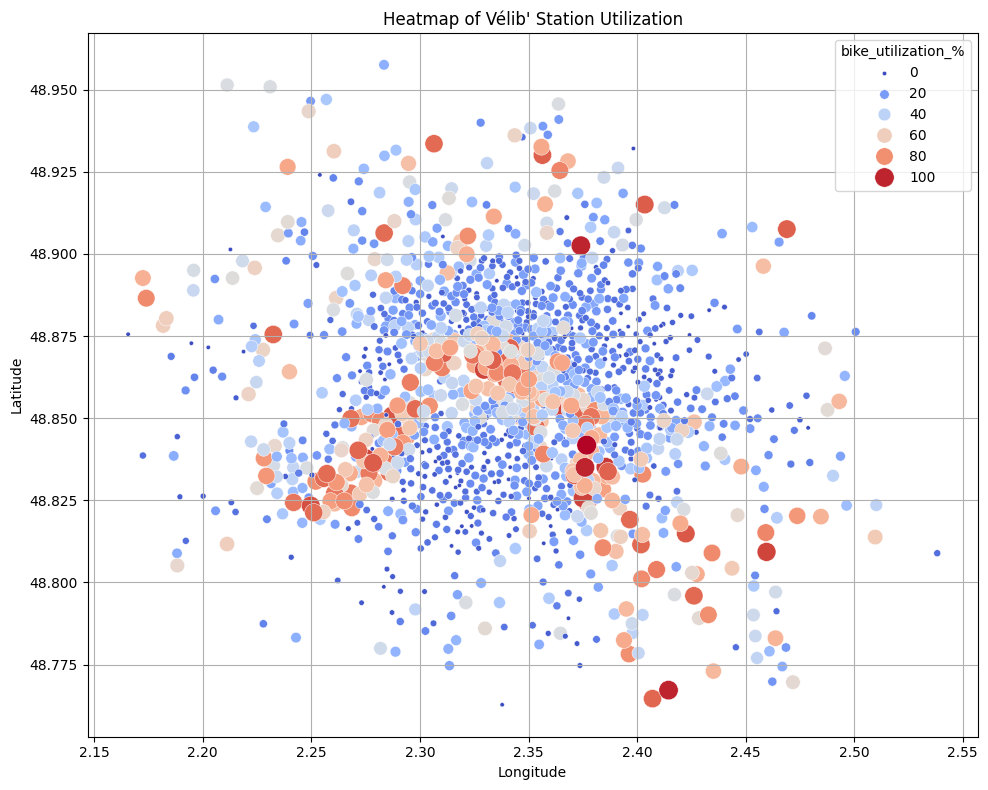

In [ ]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

info_url = "https://velib-metropole-opendata.smovengo.cloud/opendata/Velib_Metropole/station_information.json"
status_url = "https://velib-metropole-opendata.smovengo.cloud/opendata/Velib_Metropole/station_status.json"

df_info = pd.DataFrame(requests.get(info_url).json()['data']['stations'])
df_status = pd.DataFrame(requests.get(status_url).json()['data']['stations'])
df = pd.merge(df_info, df_status, on='station_id')

df = df[df['capacity'] > 0]
df['bike_utilization_%'] = (df['numBikesAvailable'] / df['capacity']) * 100

df = df[(df['lat'] > 0) & (df['lon'] > 0)]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='lon',
    y='lat',
    hue='bike_utilization_%',
    palette='coolwarm',
    size='bike_utilization_%',
    sizes=(10, 200),
    legend='brief'
)
plt.title("Heatmap of Vélib' Station Utilization")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import requests
import folium

# URLs of Vélib' APIs
info_url = "https://velib-metropole-opendata.smovengo.cloud/opendata/Velib_Metropole/station_information.json"
status_url = "https://velib-metropole-opendata.smovengo.cloud/opendata/Velib_Metropole/station_status.json"

info_data = requests.get(info_url).json()['data']['stations']
status_data = requests.get(status_url).json()['data']['stations']
df_info = pd.DataFrame(info_data)
df_status = pd.DataFrame(status_data)

df = pd.merge(df_info, df_status, on='station_id', how='inner')
df['bike_utilization_%'] = (df['numBikesAvailable'] / df['capacity']) * 100

# Create map centered in Paris
m = folium.Map(location=[48.8566, 2.3522], zoom_start=13)

for _, row in df.iterrows():
    utilization = row['bike_utilization_%']
    if utilization > 70:
        color = 'green'
    elif utilization > 30:
        color = 'orange'
    else:
        color = 'red'

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=6,
        popup=f"{row['name']}<br>Bikes: {row['numBikesAvailable']}/{row['capacity']}",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(m)

# Save map to HTML file
m.save("velib_real_map.html")

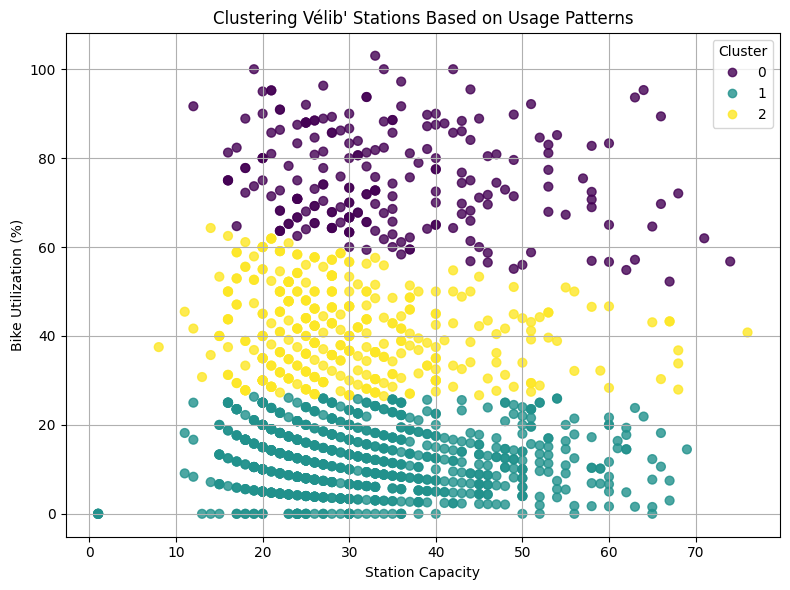

In [ ]:
import requests
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

info_url = "https://velib-metropole-opendata.smovengo.cloud/opendata/Velib_Metropole/station_information.json"
status_url = "https://velib-metropole-opendata.smovengo.cloud/opendata/Velib_Metropole/station_status.json"
df_info = pd.DataFrame(requests.get(info_url).json()['data']['stations'])
df_status = pd.DataFrame(requests.get(status_url).json()['data']['stations'])
df = pd.merge(df_info, df_status, on='station_id')

df = df[df['capacity'] > 0]
df['utilization_%'] = (df['numBikesAvailable'] / df['capacity']) * 100

def get_ebike(x):
    try:
        return x[0].get("ebike", 0)
    except:
        return 0

df['ebike'] = df['num_bikes_available_types'].apply(get_ebike)
features = df[['capacity', 'numBikesAvailable', 'ebike', 'utilization_%']]

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Visualize clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['capacity'], df['utilization_%'], c=df['cluster'], cmap='viridis', s=40, alpha=0.8)
plt.xlabel("Station Capacity")
plt.ylabel("Bike Utilization (%)")
plt.title("Clustering Vélib' Stations Based on Usage Patterns")
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import requests
from math import radians, sin, cos, sqrt, atan2

info_url = "https://velib-metropole-opendata.smovengo.cloud/opendata/Velib_Metropole/station_information.json"
station_data = requests.get(info_url).json()['data']['stations']
df = pd.DataFrame(station_data)

user_lat = 48.8566
user_lon = 2.3522

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # Distance in kilometers

df['distance_km'] = df.apply(lambda row: haversine(user_lat, user_lon, row['lat'], row['lon']), axis=1)

nearest_station = df.sort_values(by='distance_km').iloc[0]

print(f"Nearest station to ({user_lat}, {user_lon}):")
print(f"Name: {nearest_station['name']}")
print(f"Distance: {nearest_station['distance_km']:.3f} km")
print(f"Capacity: {nearest_station['capacity']}")
print(f"Station ID: {nearest_station['station_id']}")

Nearest station to (48.8566, 2.3522):
Name: Lobau - Hôtel de Ville
Distance: 0.088 km
Capacity: 60
Station ID: 98187918


In [ ]:
!pip install networkx geopy

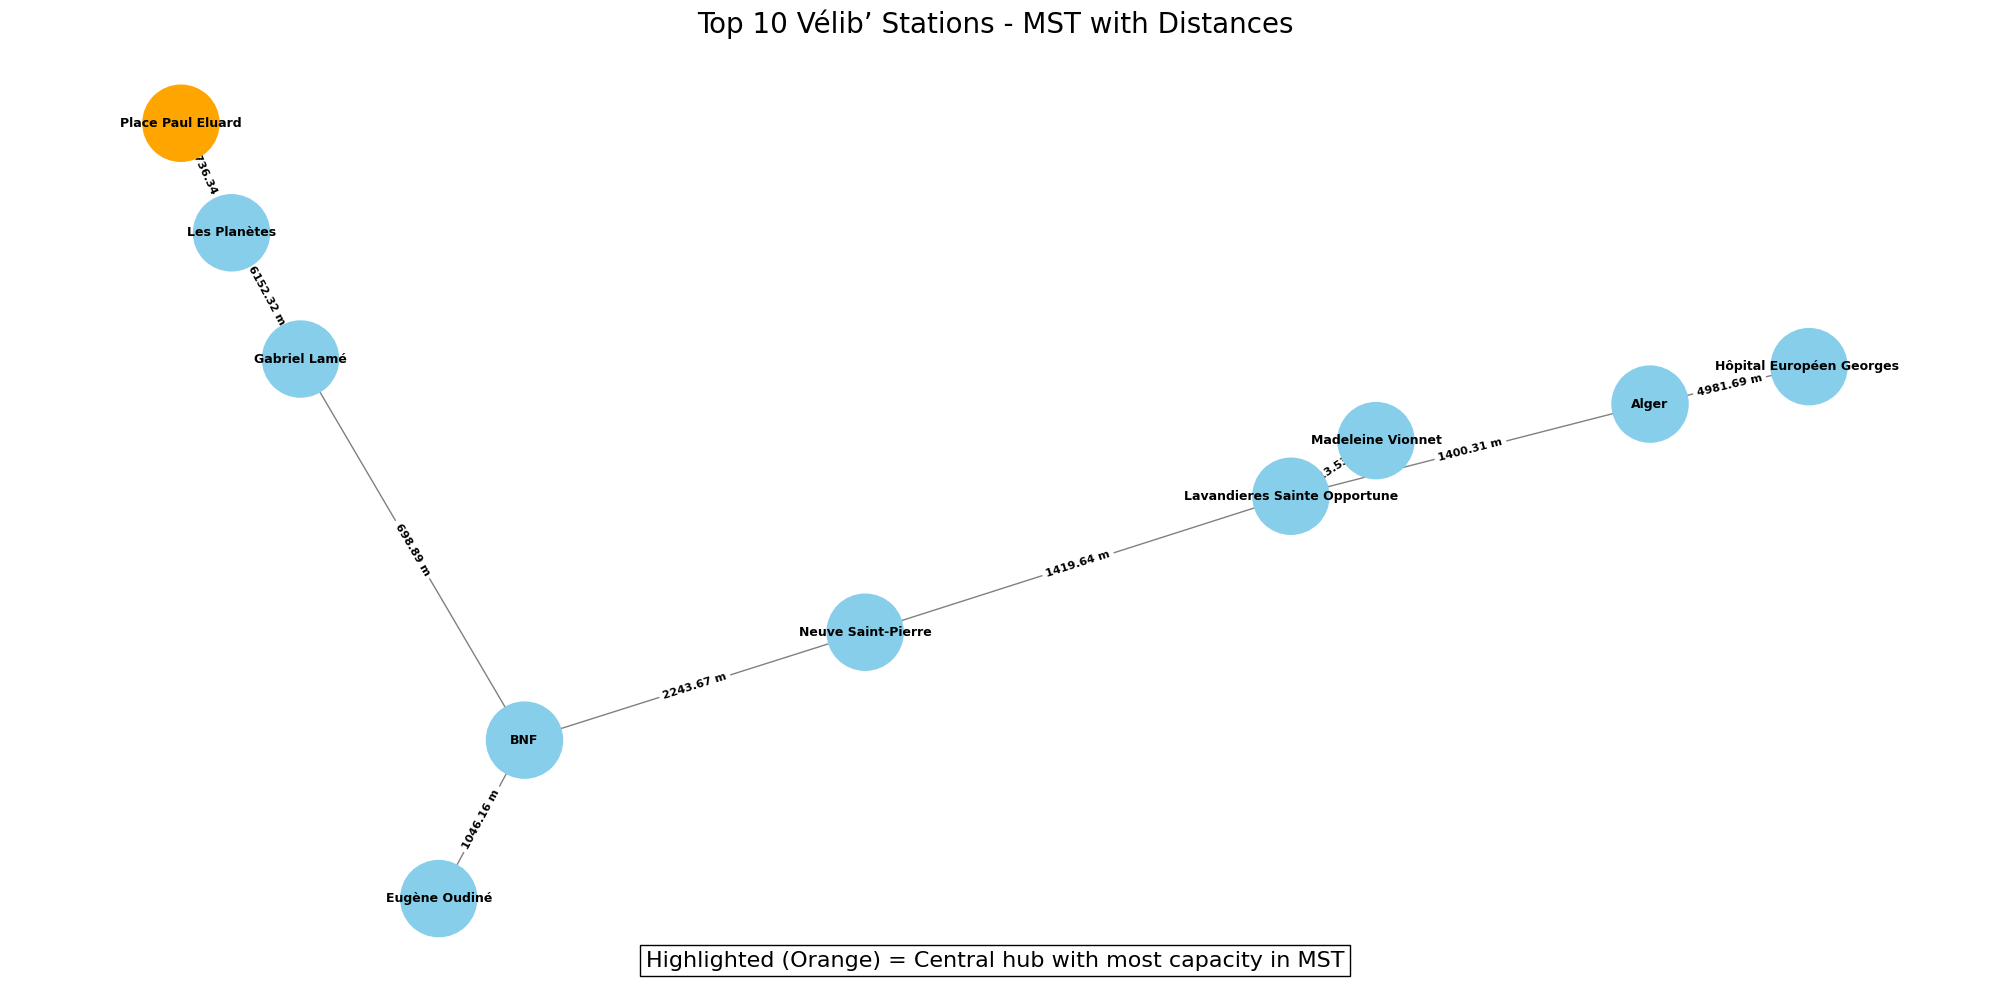

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from geopy.distance import geodesic

G = nx.Graph()
top_stations = top_10.reset_index(drop=True)

def short_name(name):
    return name.split(" - ")[0] if " - " in name else name.split(",")[0][:25]

for i, row in top_stations.iterrows():
    label = short_name(row['station_name'])
    G.add_node(i, label=label, pos=(row['longitude'], row['latitude']))

for i in range(len(top_stations)):
    loc1 = (top_stations.loc[i, 'latitude'], top_stations.loc[i, 'longitude'])
    for j in range(i + 1, len(top_stations)):
        loc2 = (top_stations.loc[j, 'latitude'], top_stations.loc[j, 'longitude'])
        dist = geodesic(loc1, loc2).meters
        G.add_edge(i, j, weight=round(dist, 2))

mst = nx.minimum_spanning_tree(G, algorithm='kruskal')

max_index = top_stations['bike_utilization_%'].idxmax()

max_degree_node = max(mst.degree, key=lambda x: x[1])[0]

initial_pos = {max_degree_node: (0, 0)}

pos = nx.spring_layout(mst, seed=42, center=(0, 0), fixed=[max_degree_node], pos=initial_pos)

node_colors = []
for node in mst.nodes():
    if node == max_index:
        node_colors.append('orange')
    else:
        node_colors.append('skyblue')

labels = nx.get_node_attributes(G, 'label')
edge_labels_raw = nx.get_edge_attributes(mst, 'weight')
edge_labels = {edge: f"{weight} m" for edge, weight in edge_labels_raw.items()}

plt.figure(figsize=(20, 10))
plt.axis('off')
nx.draw(mst, pos, with_labels=False, node_size=3000, node_color=node_colors, edge_color='gray')
nx.draw_networkx_labels(mst, pos, labels, font_size=9, font_weight='bold')
nx.draw_networkx_edge_labels(mst, pos, edge_labels=edge_labels, font_color='black', font_weight='bold', font_size=8)

plt.text(0.5, 0.01, "Highlighted (Orange) = Central hub with most capacity in MST",
         horizontalalignment='center', verticalalignment='bottom',
         transform=plt.gca().transAxes, fontsize=16, bbox=dict(facecolor='white', edgecolor='black'))

plt.title("Top 10 Vélib’ Stations - MST with Distances", fontsize=20)
plt.tight_layout()
plt.show()

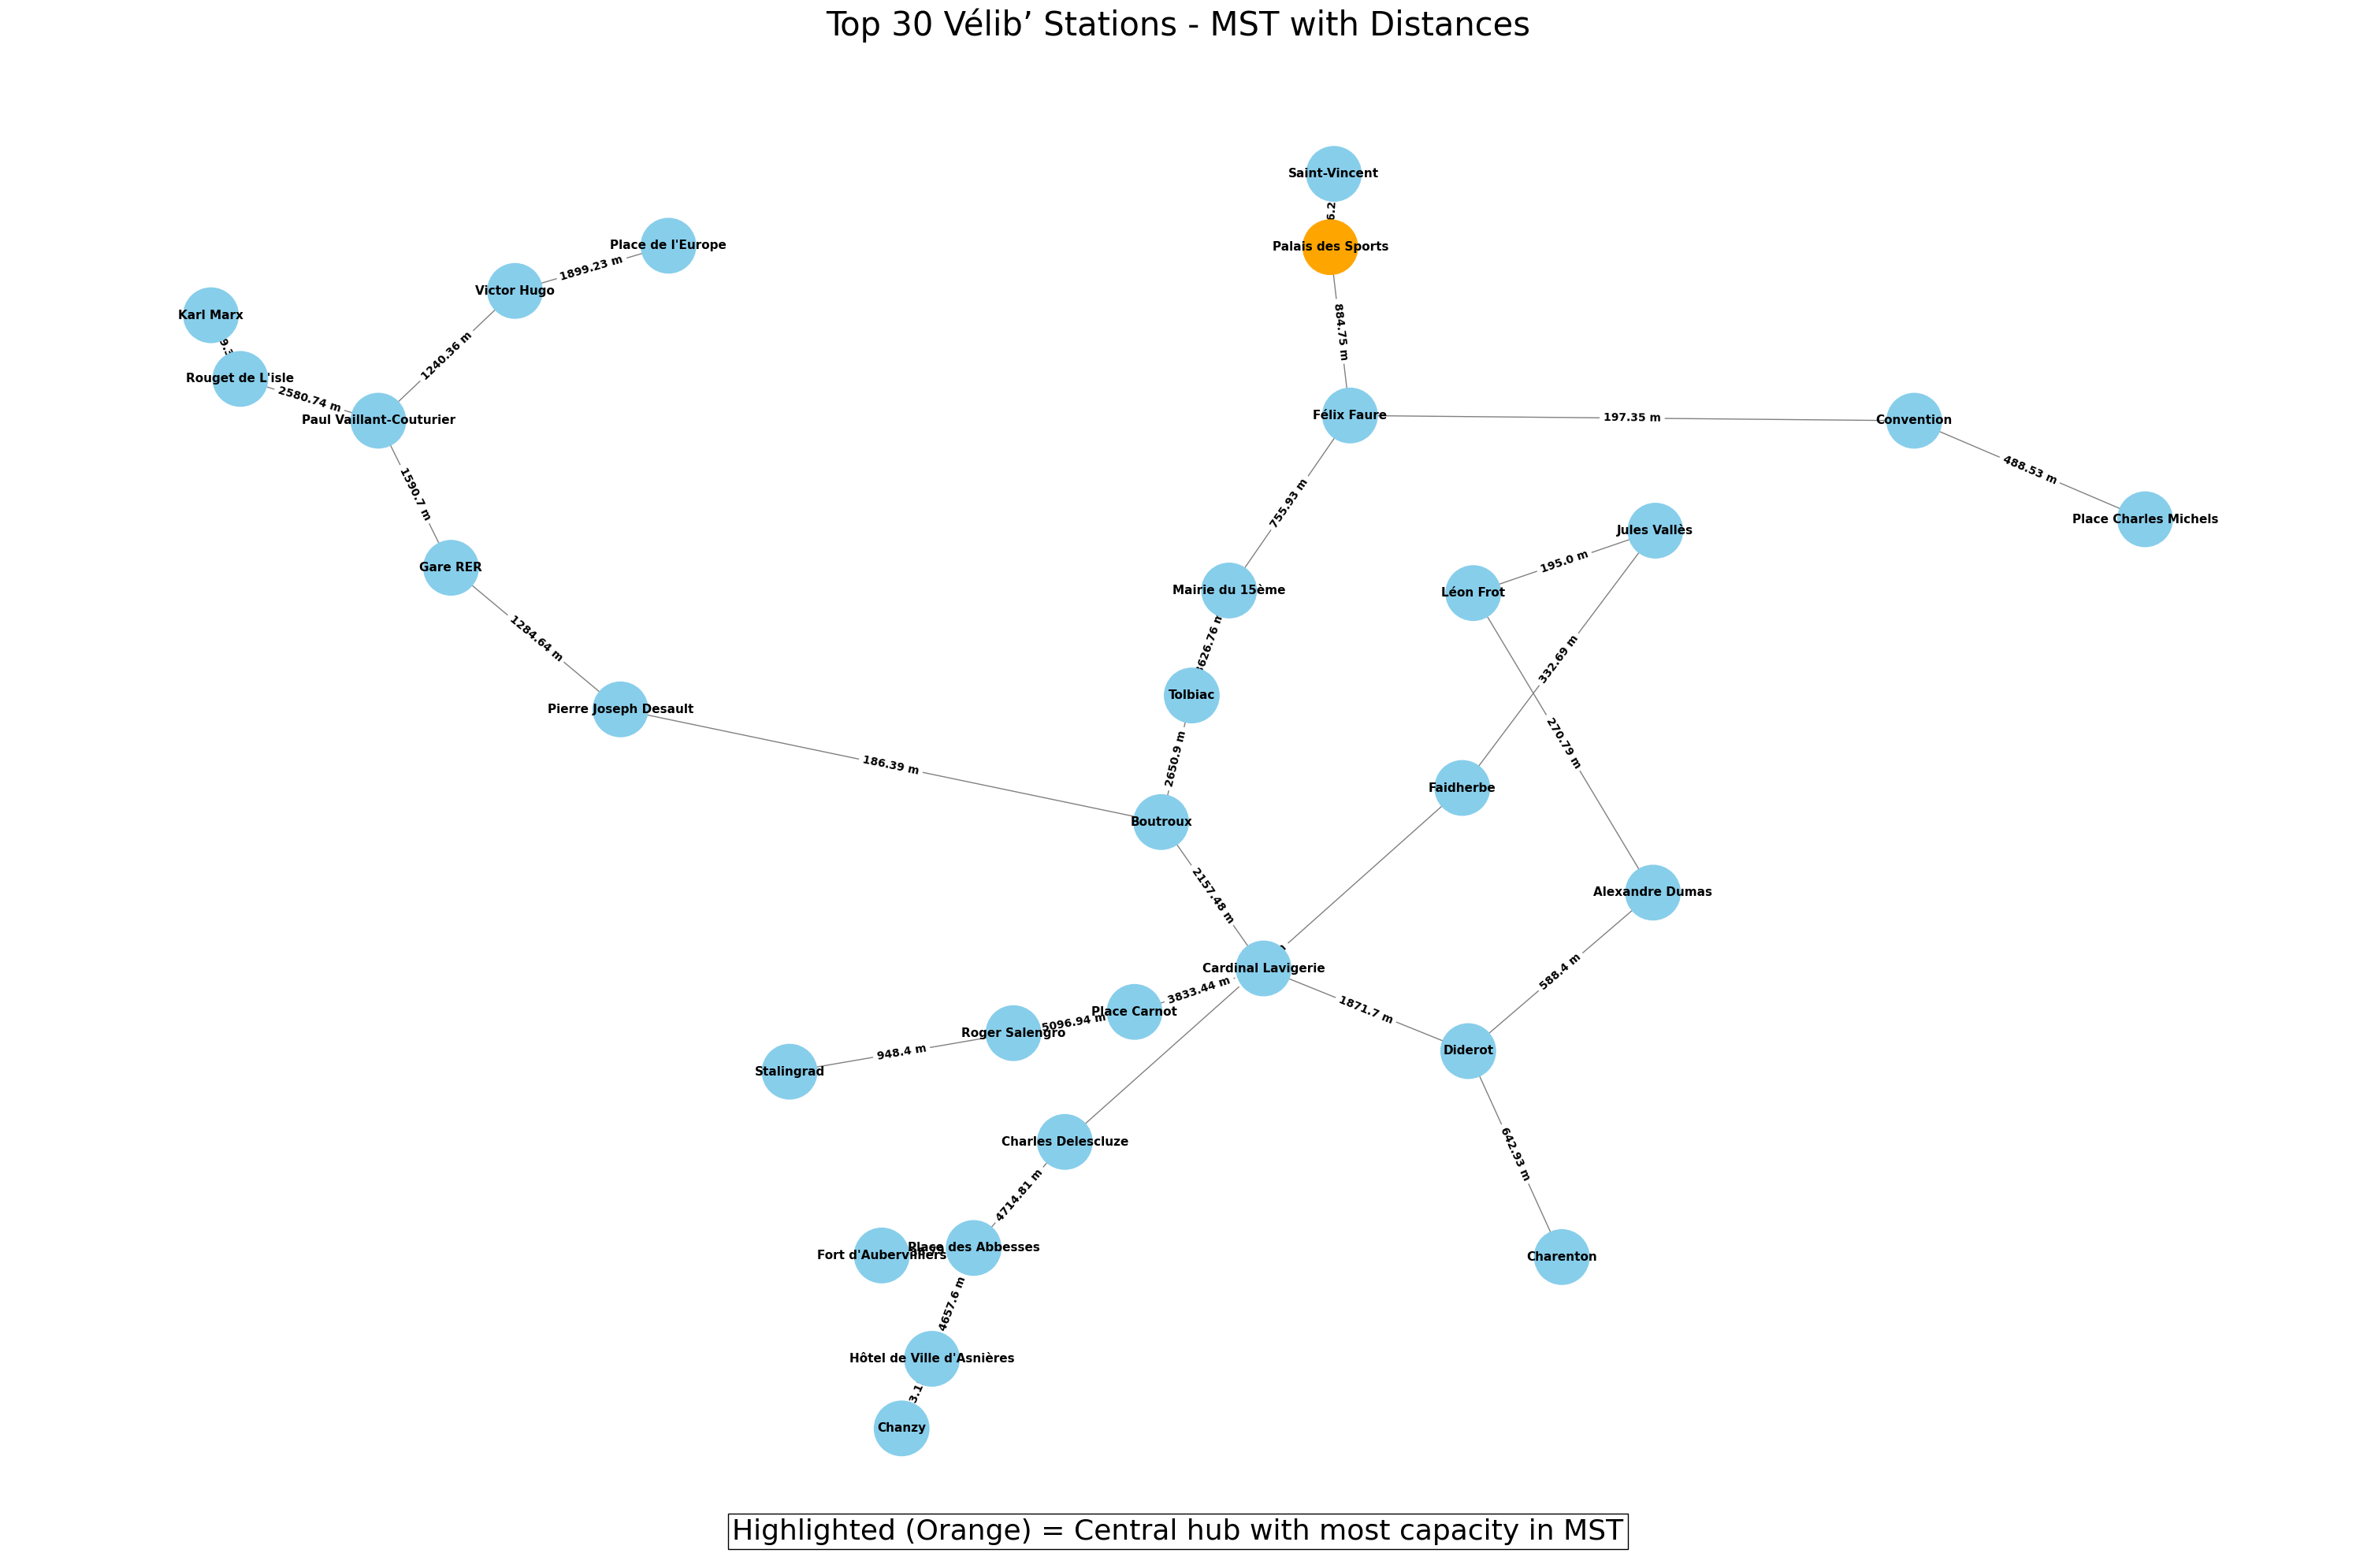

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from geopy.distance import geodesic

G = nx.Graph()
top_stations = top_30.reset_index(drop=True)

def short_name(name):
    return name.split(" - ")[0] if " - " in name else name.split(",")[0][:25]

for i, row in top_stations.iterrows():
    label = short_name(row['station_name'])
    G.add_node(i, label=label, pos=(row['longitude'], row['latitude']))

for i in range(len(top_stations)):
    loc1 = (top_stations.loc[i, 'latitude'], top_stations.loc[i, 'longitude'])
    for j in range(i + 1, len(top_stations)):
        loc2 = (top_stations.loc[j, 'latitude'], top_stations.loc[j, 'longitude'])
        dist = geodesic(loc1, loc2).meters
        G.add_edge(i, j, weight=round(dist, 2))

mst = nx.minimum_spanning_tree(G, algorithm='kruskal')
pos = nx.spring_layout(mst, seed=42, k=3)

max_index = top_stations['bike_utilization_%'].idxmax()

node_colors = []
for node in mst.nodes():
    if node == max_index:
        node_colors.append('orange')
    else:
        node_colors.append('skyblue')

labels = nx.get_node_attributes(G, 'label')
edge_labels_raw = nx.get_edge_attributes(mst, 'weight')
edge_labels = {edge: f"{weight} m" for edge, weight in edge_labels_raw.items()}

plt.figure(figsize=(30, 20))
plt.axis('off')
nx.draw(mst, pos, with_labels=False, node_size=2500, node_color=node_colors, edge_color='gray')
nx.draw_networkx_labels(mst, pos, labels, font_size=11, font_weight='bold')
nx.draw_networkx_edge_labels(mst, pos, edge_labels=edge_labels, font_color='black', font_weight='bold', font_size=10)

plt.text(0.5, 0.01, "Highlighted (Orange) = Central hub with most capacity in MST",
         horizontalalignment='center', verticalalignment='bottom',
         transform=plt.gca().transAxes, fontsize=26, bbox=dict(facecolor='white', edgecolor='black'))

plt.title("Top 30 Vélib’ Stations - MST with Distances", fontsize=30)
plt.tight_layout()
plt.show()

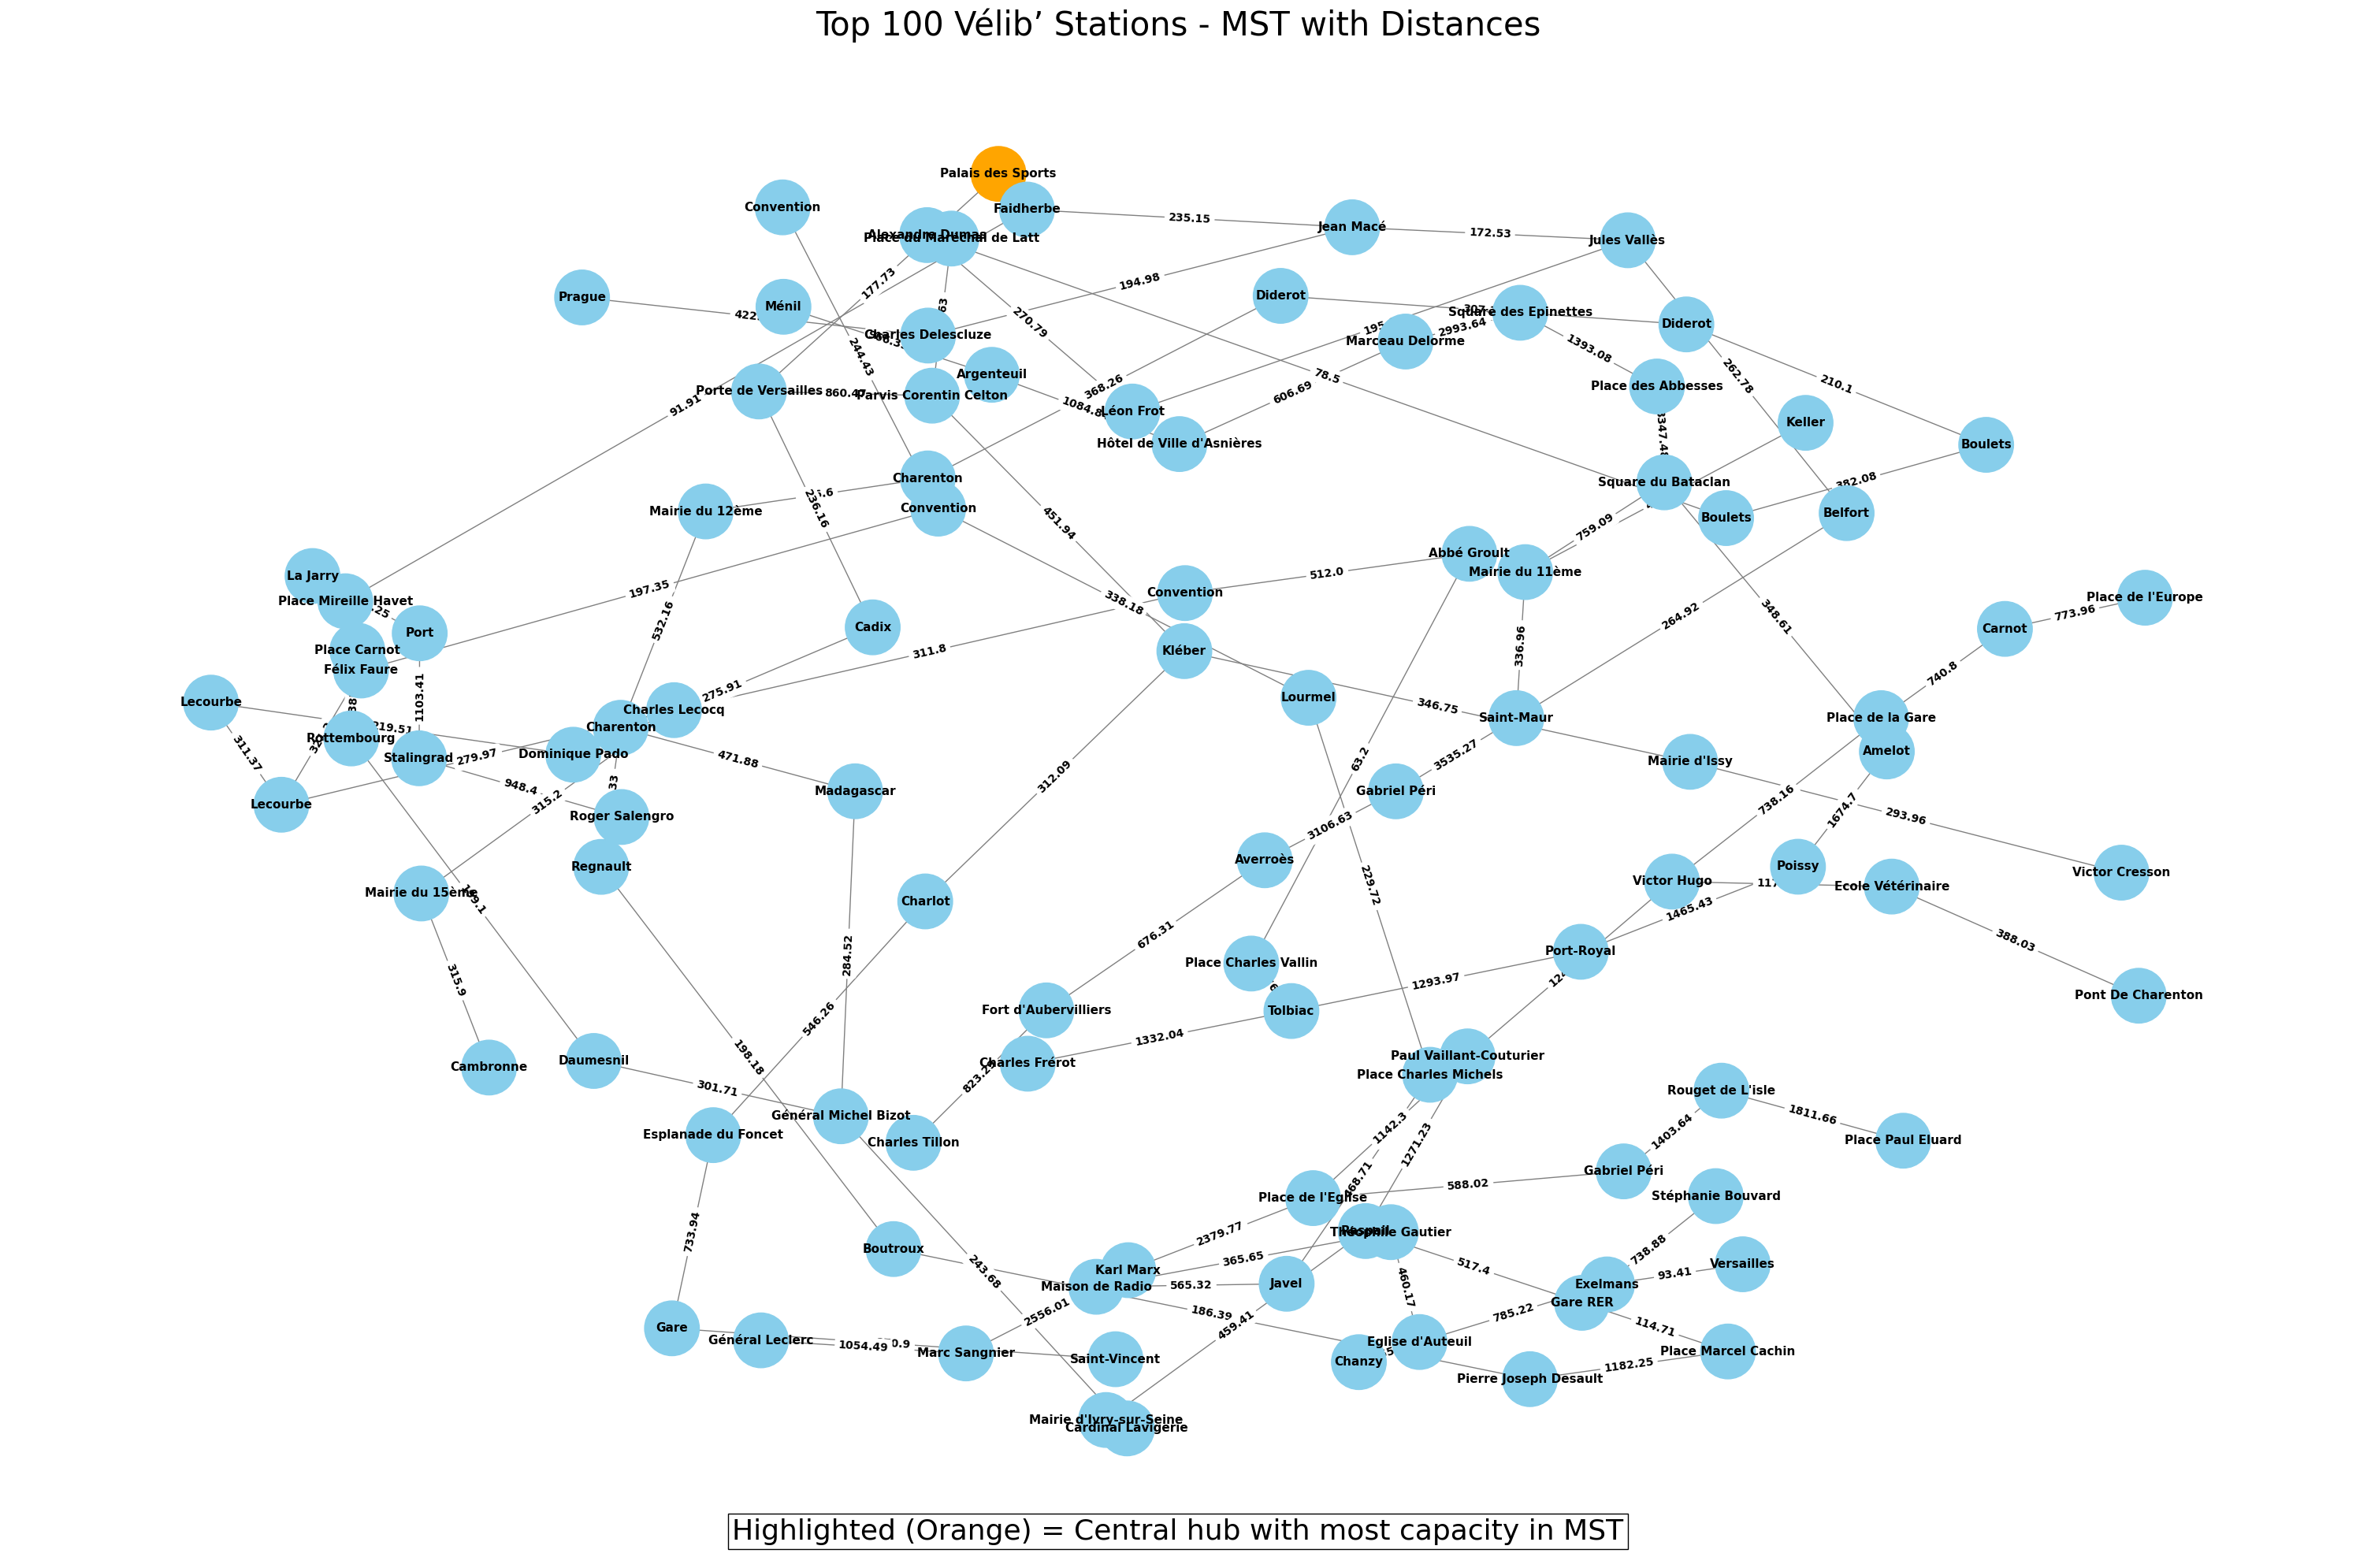

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from geopy.distance import geodesic

G = nx.Graph()
top_stations = top_100.reset_index(drop=True)

def short_name(name):
    return name.split(" - ")[0] if " - " in name else name.split(",")[0][:25]

for i, row in top_stations.iterrows():
    label = short_name(row['station_name'])
    G.add_node(i, label=label, pos=(row['longitude'], row['latitude']))

for i in range(len(top_stations)):
    loc1 = (top_stations.loc[i, 'latitude'], top_stations.loc[i, 'longitude'])
    for j in range(i + 1, len(top_stations)):
        loc2 = (top_stations.loc[j, 'latitude'], top_stations.loc[j, 'longitude'])
        dist = geodesic(loc1, loc2).meters
        G.add_edge(i, j, weight=round(dist, 2))

mst = nx.minimum_spanning_tree(G, algorithm='kruskal')
pos = nx.spring_layout(mst, seed=42, k=3)

max_index = top_stations['bike_utilization_%'].idxmax()

node_colors = []
for node in mst.nodes():
    if node == max_index:
        node_colors.append('orange')
    else:
        node_colors.append('skyblue')

labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(mst, 'weight')

plt.figure(figsize=(30, 20))
plt.axis('off')
nx.draw(mst, pos, with_labels=False, node_size=2500, node_color=node_colors, edge_color='gray')
nx.draw_networkx_labels(mst, pos, labels, font_size=11, font_weight='bold')
nx.draw_networkx_edge_labels(mst, pos, edge_labels=edge_labels, font_color='black',font_weight='bold', font_size=10)

plt.text(0.5, 0.01, "Highlighted (Orange) = Central hub with most capacity in MST",
         horizontalalignment='center', verticalalignment='bottom',
         transform=plt.gca().transAxes, fontsize=26, bbox=dict(facecolor='white', edgecolor='black'))

plt.title("Top 100 Vélib’ Stations - MST with Distances", fontsize=30)
plt.tight_layout()
plt.show()